<a href="https://colab.research.google.com/github/daureny/Dashboard_PyCh_final/blob/master/Trading_Bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


!pip install numpy pandas matplotlib gymnasium gym-anytrading stable-baselines3 yfinance pandas-ta plotly sb3-contrib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl

In [2]:
!pip install alpha_vantage

[*********************100%%**********************]  1 of 1 completed


Using cuda device
----------------------------
| time/              |     |
|    fps             | 292 |
|    iterations      | 1   |
|    time_elapsed    | 1   |
|    total_timesteps | 512 |
----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 2           |
|    time_elapsed         | 10          |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.009864944 |
|    clip_fraction        | 0.0578      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.69       |
|    explained_variance   | -4.55       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0284     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0125     |
|    value_loss           | 0.0019      |
-----------------------------------------
-----------------------

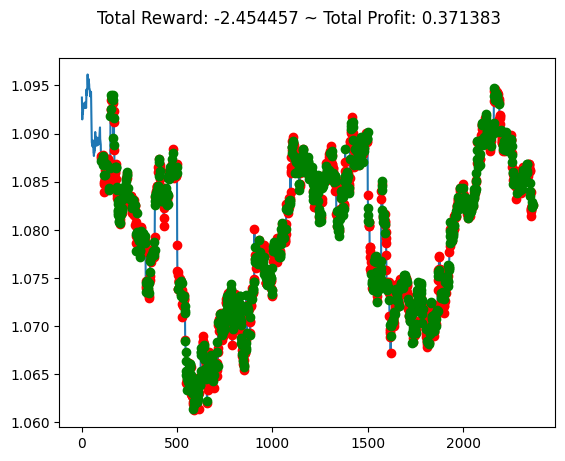

In [9]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv, Actions, Positions

import yfinance as yf
from sb3_contrib import RecurrentPPO
import pandas_ta as ta
import plotly.graph_objects as go
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

# Fetch data from Yahoo Finance
ticker = 'EURUSD=X'  # Ticker for USD/EUR currency pair
interval = '1h'  # Change to '1m', '5m', '1h', etc. for different intervals

df = yf.download(ticker, start="2022-08-30", end="2024-07-30", interval=interval)

# Create features using pandas-ta
df['feature_ret_2'] = df['Close'].pct_change(2)
df['feature_ret_5'] = df['Close'].pct_change(5)
df['feature_ret_10'] = df['Close'].pct_change(10)
df['feature_ret_21'] = df['Close'].pct_change(21)
df['feature_rsi'] = ta.rsi(df['Close'])
macd = ta.macd(df['Close'])
df['feature_macd'] = macd['MACDh_12_26_9']
df['feature_atr'] = ta.atr(df['High'], df['Low'], df['Close'])
stoch = ta.stoch(df['High'], df['Low'], df['Close'])
df['feature_stoch'] = stoch['STOCHk_14_3_3'] - stoch['STOCHd_14_3_3']
df['feature_cci'] = ta.cci(df['High'], df['Low'], df['Close'])

# Drop rows with any NaN values
df.dropna(inplace=True)

# Split the data into training and validation sets
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
val_df = df[train_size:]

# Set window size (lookback window)
window_size = 100

# Create the training environment with custom trade fees
class CustomStocksEnv(StocksEnv):
    def __init__(self, df, window_size, frame_bound, trade_fee_bid_percent=0.001, trade_fee_ask_percent=0.001):
        super().__init__(df, window_size, frame_bound)
        self.trade_fee_bid_percent = trade_fee_bid_percent
        self.trade_fee_ask_percent = trade_fee_ask_percent

    def _process_data(self):
        prices = self.df.loc[:, 'Close'].to_numpy()
        signal_features = self.df.loc[:,
                          ['feature_ret_2', 'feature_ret_5', 'feature_ret_10', 'feature_ret_21', 'feature_rsi',
                           'feature_macd', 'feature_atr', 'feature_stoch', 'feature_cci']].to_numpy()
        return prices, signal_features

    def _calculate_reward(self, action):
        step_reward = super()._calculate_reward(action)
        if action == Actions.Buy.value or action == Actions.Sell.value:
            step_reward -= self.trade_fee_ask_percent * self.prices[self._current_tick]
        return step_reward


def make_env(df, window_size, frame_bound, trade_fee_bid_percent, trade_fee_ask_percent):
    def _init():
        env = CustomStocksEnv(df, window_size, frame_bound, trade_fee_bid_percent, trade_fee_ask_percent)
        return env

    return _init


if __name__ == '__main__':
    train_envs = SubprocVecEnv(
        [make_env(train_df, window_size, (window_size, len(train_df)), 0.001, 0.001) for _ in range(4)])
    val_env = make_env(val_df, window_size, (window_size, len(val_df)), 0.001, 0.001)()

    # Initialize cash balance tracking and other variables
    initial_balance = 100000
    balance = initial_balance
    balance_history = []
    shares_held = 0
    action_stats = {Actions.Sell: 0, Actions.Buy: 0}

    # Define policy_kwargs with LSTM layers configuration
    policy_kwargs = dict(
        lstm_hidden_size=256,
        n_lstm_layers=2
    )

    # Train the PPO model on the training environment
    model = RecurrentPPO("MlpLstmPolicy", train_envs, verbose=1, policy_kwargs=policy_kwargs)
    model.learn(total_timesteps=20000)

    # Save the trained model
    model.save("ppo_usdeur_hourly_model")

    # Run the model on the validation environment
    observation, info = val_env.reset(seed=2024)
    step = 0

    while True:
        action, _states = model.predict(observation)
        current_price = val_env.unwrapped.prices[val_env.unwrapped._current_tick]

        observation, reward, terminated, truncated, info = val_env.step(action)

        # Trade logic
        trade_amount = balance  # Trade with 100% of current balance

        if action == Actions.Buy.value:
            shares_to_buy = trade_amount / current_price
            balance -= trade_amount  # removed trading fees as they are already included in val_env
            shares_held += shares_to_buy
            print(f"{step}: BUY  {shares_to_buy:.2f} shares at ${current_price:.2f} | Balance: ${balance:.2f}")
        elif action == Actions.Sell.value and shares_held > 0:
            balance += shares_held * current_price  # removed trading fees as they are already included in val_env
            print(f"{step}: SELL {shares_held:.2f} shares at ${current_price:.2f} | Balance: ${balance:.2f}")
            shares_held = 0
        else:
            print(f"{step}: HOLD | Current price: ${current_price:.2f} | Balance: ${balance:.2f}")

        action_stats[Actions(action)] += 1
        balance_history.append(balance + shares_held * current_price)

        step += 1
        if terminated or truncated:
            print("info:", info)
            break

    # If we still hold shares at the end, sell them all
    if shares_held > 0:
        balance += shares_held * current_price
        print(f"\nFinal SELL {shares_held:.2f} shares at ${current_price:.2f} | Balance: ${balance:.2f}")
        shares_held = 0

    val_env.close()

    print("Action stats:", action_stats)
    print(f"Final Balance: ${balance:.2f}")

    # Buy and hold strategy for comparison
    buy_and_hold_balance = initial_balance
    buy_and_hold_shares = initial_balance / val_df['Close'].iloc[window_size]
    buy_and_hold_history = buy_and_hold_shares * val_df['Close'].iloc[window_size:]

    buy_and_hold_history = list(buy_and_hold_history.values)  # added the list of values

    # Plot the results using Plotly
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=val_df.index, y=balance_history, mode='lines', name='RL Strategy'))
    fig.add_trace(go.Scatter(x=val_df.index, y=buy_and_hold_history, mode='lines', name='Buy and Hold'))

    fig.update_layout(
        title=f'Portfolio Value Over Time ({ticker})',
        xaxis_title='Date',
        yaxis_title='Portfolio Value ($)',
        legend=dict(x=0, y=1, traceorder='normal'),
        hovermode="x unified"
    )

    fig.show()

    plt.cla()
    val_env.unwrapped.render_all()
    plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
